# Word Embeeding e LSTM

Quando os dados são textos, devemos de alguma forma transformar estes em vetores numéricos para que a maioria dos modelos possam ser treinados. Veremos algumas formas de vetorizar texto.

Utilizaremos dados do Twitter que podem ser baixados em:

- https://www.kaggle.com/datasets/kazanova/sentiment140
- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

In [50]:
import pandas as pd
import numpy as np

# texto
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize # Slow!
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modelo
from sklearn.naive_bayes import BernoulliNB

# métricas
from sklearn.metrics import classification_report

# utils
from collections import Counter
from sklearn.model_selection import train_test_split

# keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Flatten, GRU, Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(
    "../datasets/Tweets/tweets.csv", encoding='latin-1',
    names=["Sentiment", "ID", "Date", "Query", "User", "Tweet"]
)
df.head(3)

## Limpeza de dados textuais

In [ ]:
# removendo colunas desnecessárias
df.drop(['ID', 'Date', 'Query', 'User'], axis=1, inplace=True)

In [ ]:
# deixando todos os caracteres minúsculos
df['Tweet'] = df['Tweet'].map(str.lower)

In [ ]:
# removendo pontuações e marcações de usuários
def RemovePunctuation(x):
    x = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",x).split())
    return re.sub("["+string.punctuation+"]", r" ", x)
df['Tweet'] = df['Tweet'].map(RemovePunctuation)

In [ ]:
# removendo números
def RemoveNumbers(x):
    res = re.sub(r'[0-9]+',r' ',x)
    return res
df['Tweet'] = df['Tweet'].map(RemoveNumbers)

In [ ]:
# removendo stopwords
df['Tweet'] = df['Tweet'].map(remove_stopwords)

In [ ]:
# removendo caracteres isolados
def removeSingleChars(text):
    words = text.split()
    return " ".join([w for w in words if len(w) > 1])
df['Tweet'] = df['Tweet'].map(removeSingleChars)

In [ ]:
### PULAR ###

# extraindo a raiz da palavra
# para português: # st = nltk.SnowballStemmer('portuguese')
# Lemmatization vs Stemmering (Lemma is a word)

st = PorterStemmer()
def stemming_on_text(data):
    data_split = data.split()
    text = [st.stem(word) for word in data_split]
    return text
df['Tweet']= df['Tweet'].map(stemming_on_text)

In [ ]:
lm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    data_split = data.split()
    text = [lm.lemmatize(word) for word in data_split]
    return text
df['Tweet'].map(lemmatizer_on_text)

0          [http, twitpic, com, zl, awww, bummer, shoulda...
1          [upset, update, facebook, texting, result, sch...
2            [dived, time, ball, managed, save, rest, bound]
3                                  [body, feel, itchy, like]
4                                            [behaving, mad]
                                 ...                        
1599995                [woke, having, school, best, feeling]
1599996    [thewdb, com, cool, hear, old, walt, interview...
1599997                 [ready, mojo, makeover, ask, detail]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999                              [happy, charitytuesday]
Name: Tweet, Length: 1600000, dtype: object

In [ ]:
df.to_csv('../datasets/Tweets/clean_tweets.csv', index=None, encoding="utf-8")

## Limpando a memória

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             X: 691.3 MiB
                       X_train: 656.7 MiB
                        X_test: 34.6 MiB
                             y: 24.3 MiB
                       y_train: 23.0 MiB
                     all_words:  8.0 MiB
                        y_test:  1.2 MiB
                        y_pred: 621.0 KiB
                           _14:  2.4 KiB
                           _15:  2.4 KiB


In [ ]:
del X
del X_train
del X_test

## Continuando ...

# Vetorização com TF-IDF

In [ ]:
df = pd.read_csv('../datasets/Tweets/clean_tweets.csv')
df.dropna(inplace=True)
X = df['Tweet']
y = df['Sentiment']
del df
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558

In [ ]:
%% time
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
%% time
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

In [ ]:
y_pred = BNBmodel.predict(X_test)
print(classification_report(y_pred, y_test)) # 77%

              precision    recall  f1-score   support

           0       0.77      0.78      0.77     39447
           4       0.78      0.77      0.77     40033

    accuracy                           0.77     79480
   macro avg       0.77      0.77      0.77     79480
weighted avg       0.77      0.77      0.77     79480



## Vetorização com OneHot

In [ ]:
df = pd.read_csv('../datasets/Tweets/clean_tweets.csv')
df.dropna(inplace=True)
X = df['Tweet']
y = df['Sentiment']

In [ ]:
all_words = set()
for row in df['Tweet'].values:
    for word in row.split():
        all_words.add(word)
len(all_words)

In [ ]:
%%time
# não haverá unicidade com 500
# mesma palavra mesmo encoding (não considera contexto)
# vetor muito grande se unicidade
df["Tweet"] = df["Tweet"].map(lambda x: one_hot(x, 500))

CPU times: total: 8.36 s
Wall time: 11.5 s


In [ ]:
df["Tweet"].head()

0    [19, 151, 310, 370, 355, 200, 49, 304, 373, 31...
1             [271, 111, 282, 136, 318, 401, 346, 311]
2                    [379, 362, 265, 401, 499, 34, 47]
3                                  [347, 155, 192, 28]
4                                            [312, 62]
Name: Tweet, dtype: object

In [ ]:
df["Tweet_count_words"] = df["Tweet"].map(len)
print(df['Tweet_count_words'].max(), df['Tweet_count_words'].min())

114 1


In [ ]:
X = pad_sequences(
    df["Tweet"],
    maxlen=114,
    padding='post',
    truncating='post',
    value=0.0)
y = df['Sentiment']

In [ ]:
X[:2]

array([[ 19, 151, 310, 370, 355, 200,  49, 304, 373, 310,  46,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [271, 111, 282, 136, 318, 401, 346, 311,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
del df
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred = BNBmodel.predict(X_test)
print(classification_report(y_pred, y_test)) # 77%

              precision    recall  f1-score   support

           0       0.59      0.50      0.55     46864
           4       0.41      0.50      0.46     32616

    accuracy                           0.50     79480
   macro avg       0.50      0.50      0.50     79480
weighted avg       0.52      0.50      0.51     79480



## Exercícios

Resolva o mesmo problema transformando textos com as duas técnicas abaixo:

Count vectorizing (1,2 Ngrams), Bag of words e One Hot Encoding N-Grams
- https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22

## Vetorização com Embeedings

https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer

In [ ]:
df = pd.read_csv('clean_tweets.csv')
df.dropna(inplace=True)
X = df['Tweet']
y = df['Sentiment'].map({0:0, 4:1})

In [ ]:
all_words = set()
for row in df['Tweet'].values:
    for word in row.split():
        all_words.add(word)
len(all_words)

314082

In [ ]:
df["Tweet_count_words"] = df["Tweet"].map(len)
print(df['Tweet_count_words'].max(), df['Tweet_count_words'].min())

362 2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index=tokenizer.word_index
vocab_size = len(word_index)+1

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
model = Sequential([
    Embedding(vocab_size, 20, input_length=maxlen),
    Bidirectional(LSTM(64)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compiles model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
%%time
model.fit(X_train_pad, y_train, batch_size=512, epochs=2, verbose=1)

Epoch 1/2
2950/2950 [==============================] - 118s 38ms/step - loss: 0.4782 - accuracy: 0.7699
Epoch 2/2
2950/2950 [==============================] - 58s 20ms/step - loss: 0.4289 - accuracy: 0.8007
CPU times: user 2min 37s, sys: 5.75 s, total: 2min 42s
Wall time: 2min 56s


In [ ]:
y_pred = model.predict(X_test_pad)
print(classification_report(y_pred.ravel().round(0), y_test)) # 77%

2484/2484 [==============================] - 12s 5ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78     39349
         1.0       0.79      0.78      0.78     40131

    accuracy                           0.78     79480
   macro avg       0.78      0.78      0.78     79480
weighted avg       0.78      0.78      0.78     79480



- https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/

# Séries temporais com LSTM

In [161]:
import yfinance as yf
# modelo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import initializers, activations
from tensorflow.keras.layers import Activation
# transform
from sklearn.preprocessing import MinMaxScaler 
# utils
import math
import numpy as np
# eda
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

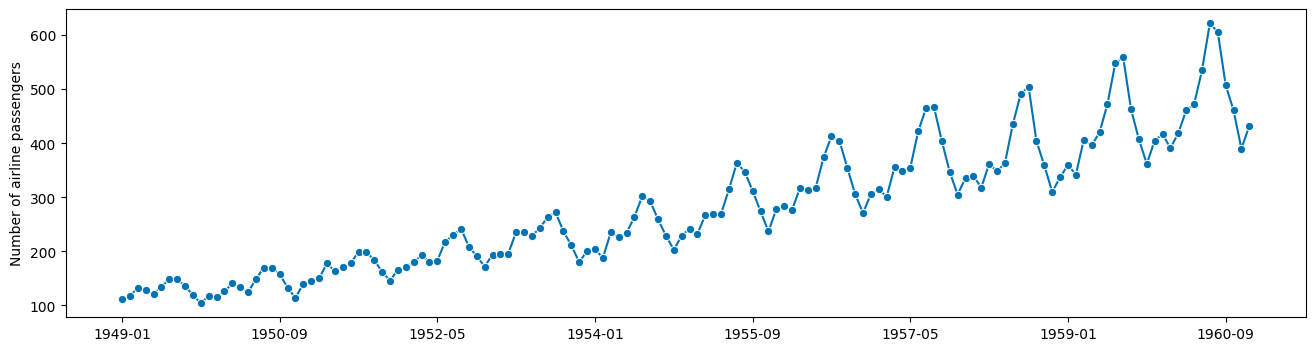

In [162]:
from sktime.datasets import load_airline
data = load_airline()
plot_series(data)
plt.show()

In [163]:
values = data.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

window_size = 60
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [164]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56, 60, 1), (28, 60, 1), (56,), (28,))

In [165]:
def get_model(x_train):
    model = Sequential([
        LSTM(80, 
             input_shape=(x_train.shape[1], x_train.shape[2]),
             return_sequences=True,
        ),
        LSTM(80, return_sequences=False),
        Dense(10),
        Dense(1)
    ])
    model.compile(optimizer="adam",loss='mean_squared_error',metrics=['mape'])
    return model

In [166]:
model = get_model(x_train)
history = model.fit(
    x_train, y_train, 
    batch_size= 1, 
    epochs=50,
    verbose=0)

In [167]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

1/1 [==============================] - 1s 967ms/step
RMSE 18.920901707240514


In [168]:
result_df = pd.DataFrame({'pred': y_pred.ravel(), 'test': y_test.ravel()})
result_df.index = data[training_data_len:].index
y_pred = result_df['pred']
y_test = result_df['test']

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='pred'>)

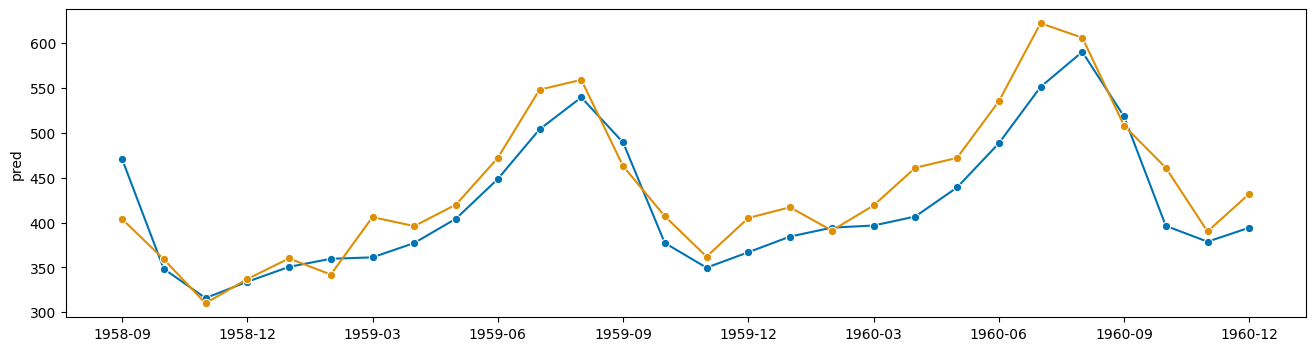

In [169]:
plot_series(y_pred, y_test)

## Mercado de ações: Endôgenea com LSTM

- https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [4]:
df = yf.download(
    'TAEE3.SA',
    start='2020-01-01',
    end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,10.29,10.42,10.01,10.11,7.206003,55500
2020-01-03,10.19,10.35,10.08,10.29,7.334301,39400
2020-01-06,10.28,10.43,10.14,10.34,7.369939,22200
2020-01-07,10.58,10.58,10.11,10.24,7.298663,36400
2020-01-08,10.26,10.30,10.10,10.24,7.298663,52700


<AxesSubplot: xlabel='Date'>

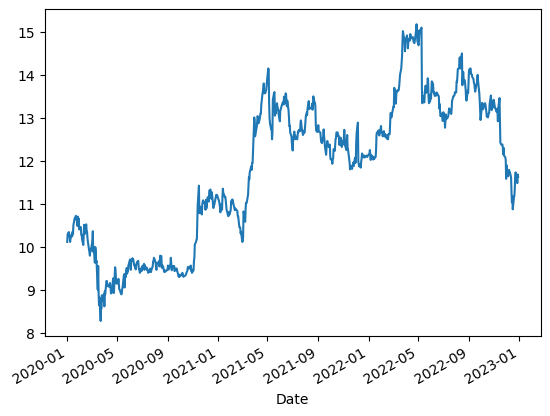

In [6]:
df['Close'].plot()

In [18]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
x_train.shape, x_test.shape, df.shape

((536, 60, 1), (149, 60, 1), (745, 5))

In [72]:
def get_model(x_train):
    model = Sequential([
        LSTM(100, 
             return_sequences=True, 
             activation="tanh", 
             input_shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(100, return_sequences=False, activation="tanh"),
        Dense(10),
        Dense(1)
    ])
    model.compile(optimizer="adam",loss='mean_squared_error',metrics=['mape'])
    return model

In [21]:
model = get_model()
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
536/536 [==============================] - 10s 14ms/step - loss: 0.0062 - mape: 13.2108
Epoch 2/3
536/536 [==============================] - 8s 14ms/step - loss: 0.0031 - mape: 10.3164
Epoch 3/3
536/536 [==============================] - 8s 15ms/step - loss: 0.0020 - mape: 8.9829


In [23]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

5/5 [==============================] - 0s 15ms/step
RMSE 0.2190538380770075


In [38]:
df.index = df.index.to_period(freq='D')
df.index

PeriodIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
             '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
             '2020-01-14', '2020-01-15',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
             '2022-12-28', '2022-12-29'],
            dtype='period[D]', name='Date', length=745)

In [51]:
df["Pred"] = 1
df["Pred"][len(train_data):] = y_pred.ravel()

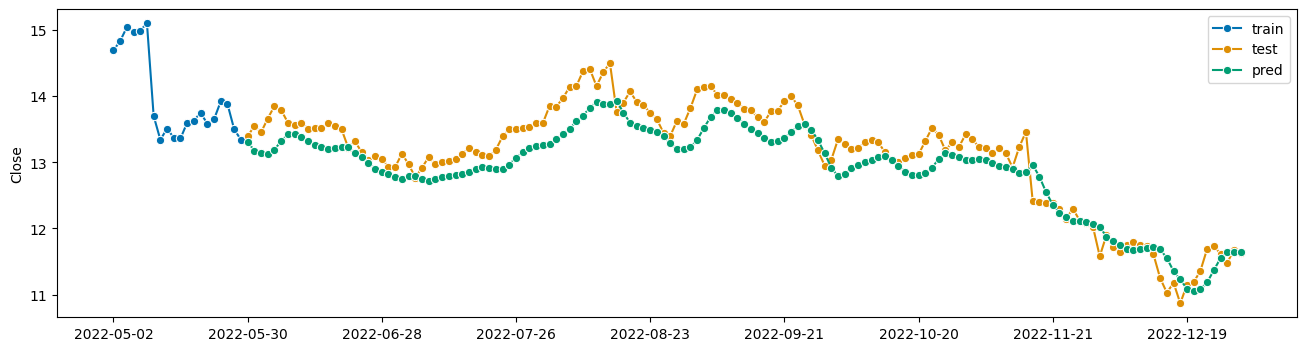

In [52]:
train = df.iloc[:len(train_data)]['Close']
test = df.iloc[len(train_data):]['Close']
pred = df.iloc[len(train_data):]['Pred']
plot_series(train[-20:], test, pred, labels=['train', 'test', 'pred'])
plt.show()

## Mercado de ações: Exôgeneas com LSTM

In [85]:
df = yf.download(
    'TAEE3.SA',
    start='2020-01-01',
    end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [68]:
data = df.drop(['Adj Close'], axis=1)
values = data.values
training_data_len = math.ceil(len(values)* 0.8)
window_size = 60

train_data = df[:training_data_len].copy()
test_data = df[training_data_len-window_size:].copy()

scalerx = MinMaxScaler(); 
scalery = MinMaxScaler();
xtrain_scaled = pd.DataFrame(scalerx.fit_transform(train_data), columns=train_data.columns)
ytrain_scaled = pd.DataFrame(scalery.fit_transform(train_data['Close'].values.reshape(-1,1)))
xtest_scaled = pd.DataFrame(scalerx.transform(test_data), columns=test_data.columns)
ytest_scaled = pd.DataFrame(scalery.transform(test_data['Close'].values.reshape(-1,1)))

x_train = []; y_train = []
for i in range(window_size, len(xtrain_scaled)):
    x_train.append(xtrain_scaled[i-window_size:i])
    y_train.append(ytrain_scaled[0][i])

x_test = []; y_test = []
for i in range(window_size, len(xtest_scaled)):
    x_test.append(xtest_scaled[i-window_size:i])
    y_test.append(ytest_scaled[0][i])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [71]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((536, 60, 6), (149, 60, 6), (536,), (149,))

In [86]:
model = get_model(x_train)
model.fit(x_train, y_train, batch_size=16, epochs=30)

Epoch 1/30
34/34 [==============================] - 4s 33ms/step - loss: 0.0236 - mape: 24.7102
Epoch 2/30
34/34 [==============================] - 1s 32ms/step - loss: 0.0031 - mape: 11.3899
Epoch 3/30
34/34 [==============================] - 1s 33ms/step - loss: 0.0024 - mape: 9.4253
Epoch 4/30
34/34 [==============================] - 1s 33ms/step - loss: 0.0022 - mape: 9.0895
Epoch 5/30
34/34 [==============================] - 1s 32ms/step - loss: 0.0026 - mape: 9.6128
Epoch 6/30
34/34 [==============================] - 1s 32ms/step - loss: 0.0023 - mape: 9.1357
Epoch 7/30
34/34 [==============================] - 1s 33ms/step - loss: 0.0017 - mape: 8.2261
Epoch 8/30
34/34 [==============================] - 1s 33ms/step - loss: 0.0019 - mape: 8.8526
Epoch 9/30
34/34 [==============================] - 1s 32ms/step - loss: 0.0019 - mape: 8.5030
Epoch 10/30
34/34 [==============================] - 1s 32ms/step - loss: 0.0016 - mape: 8.0825
Epoch 11/30
34/34 [============================

In [87]:
y_pred = model.predict(x_test)
y_pred = scalery.inverse_transform(y_pred)
print("RMSE", np.sqrt(np.mean(y_pred - y_test)**2))

5/5 [==============================] - 1s 15ms/step
RMSE 12.392051240597148


In [88]:
df.index = df.index.to_period(freq='D')
df.index

PeriodIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
             '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
             '2020-01-14', '2020-01-15',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
             '2022-12-28', '2022-12-29'],
            dtype='period[D]', name='Date', length=745)

In [89]:
df["Pred"] = 1
df["Pred"][len(train_data):] = y_pred.ravel()

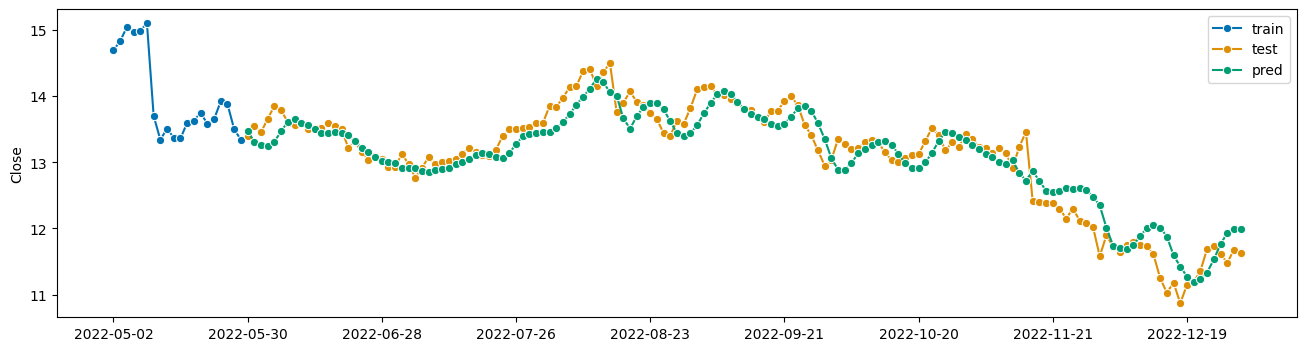

In [90]:
train = df.iloc[:len(train_data)]['Close']
test = df.iloc[len(train_data):]['Close']
pred = df.iloc[len(train_data):]['Pred']
plot_series(train[-20:], test, pred, labels=['train', 'test', 'pred'])
plt.show()

# Atividade avaliativa

Faça uma submissão no desafio https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/submissions

- **Meta 10**: 0.4
- **Meta 07**: 1.2
- **Meta 04**: 7
- **Meta 00**: >= 18